In [1]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

In [3]:
RESULTS_DIR = 'results/kubernetes'

In [4]:
data = defaultdict(list)
for filename in os.listdir(RESULTS_DIR):
    if not (filename.startswith('latency_') and filename.endswith('.json')): continue
    with open(os.path.join(RESULTS_DIR, filename), 'r') as writer:
        latency_results = json.load(writer)
        for key in latency_results:
            data[key].extend(latency_results[key])

data = {key: pd.Series(data[key]) * 1000 for key in data}
data

{'payment': 0        41.724443
 1        21.863699
 2        17.848730
 3        18.631697
 4        27.427673
            ...    
 38246    21.772146
 38247    21.331549
 38248    31.420231
 38249    42.315483
 38250    20.381212
 Length: 38251, dtype: float64,
 'order': 0         56.643248
 1         44.799328
 2         34.463882
 3         56.295395
 4         32.625675
             ...    
 39621     42.367697
 39622     29.811859
 39623     33.313036
 39624     33.356428
 39625    200.894833
 Length: 39626, dtype: float64,
 'delivery': 0        47.740936
 1        28.411150
 2        32.834768
 3        44.684649
 4        37.315369
            ...    
 3366     44.954538
 3367    242.096901
 3368     58.046579
 3369     47.711611
 3370     45.591831
 Length: 3371, dtype: float64,
 'order_status': 0       28.955936
 1       20.797253
 2       11.649370
 3       16.339064
 4       17.249584
           ...    
 3482    14.645338
 3483    16.934395
 3484    19.485712
 3485    36.500

# Plots

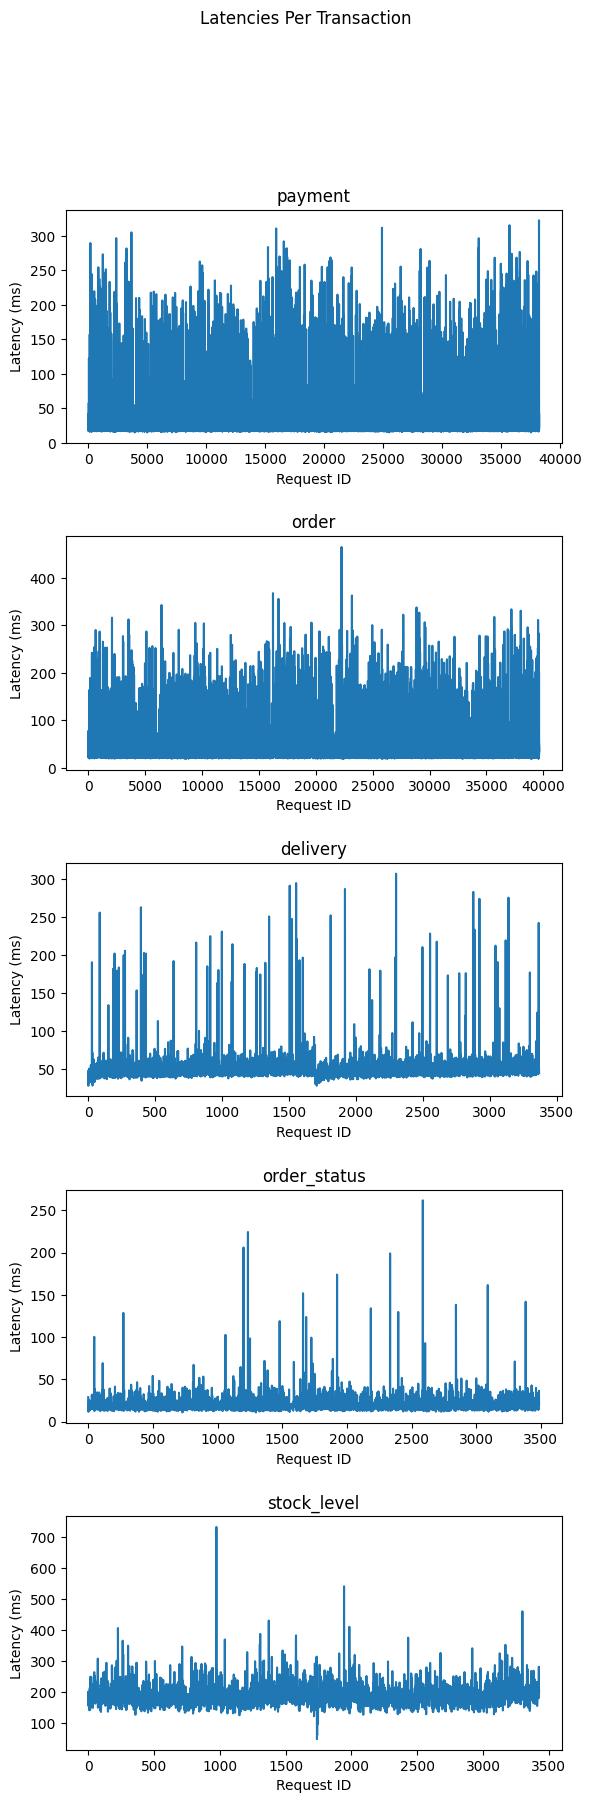

In [5]:
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('Latencies Per Transaction')
for i, key in enumerate(data):
    axes[i].plot(data[key])
    axes[i].set_title(key)
    axes[i].set_xlabel('Request ID')
    axes[i].set_ylabel('Latency (ms)')
figure.savefig(os.path.join(RESULTS_DIR, 'latency.png'))

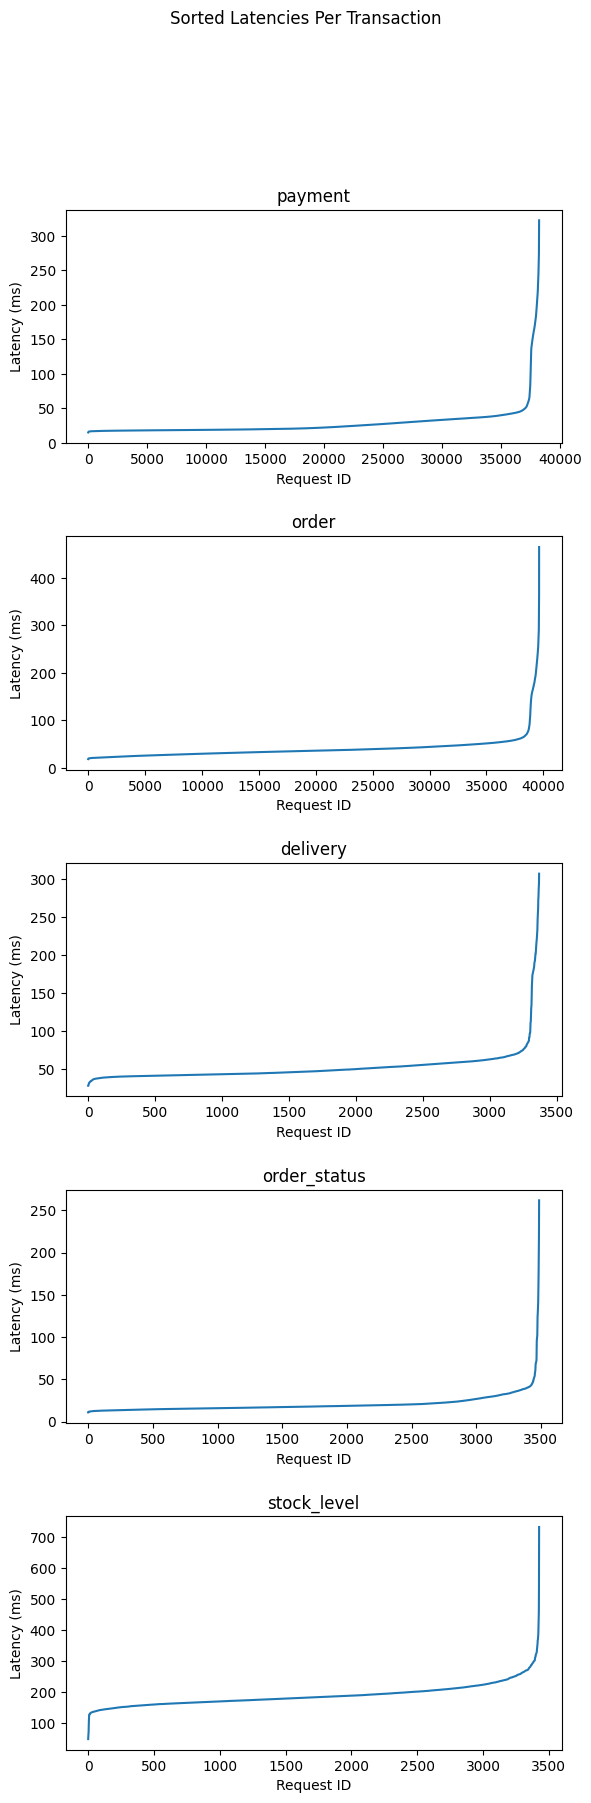

In [6]:
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('Sorted Latencies Per Transaction')
for i, key in enumerate(data):
    axes[i].plot(sorted(data[key]))
    axes[i].set_title(key)
    axes[i].set_xlabel('Request ID')
    axes[i].set_ylabel('Latency (ms)')
figure.savefig(os.path.join(RESULTS_DIR, 'sorted_latency.png'))

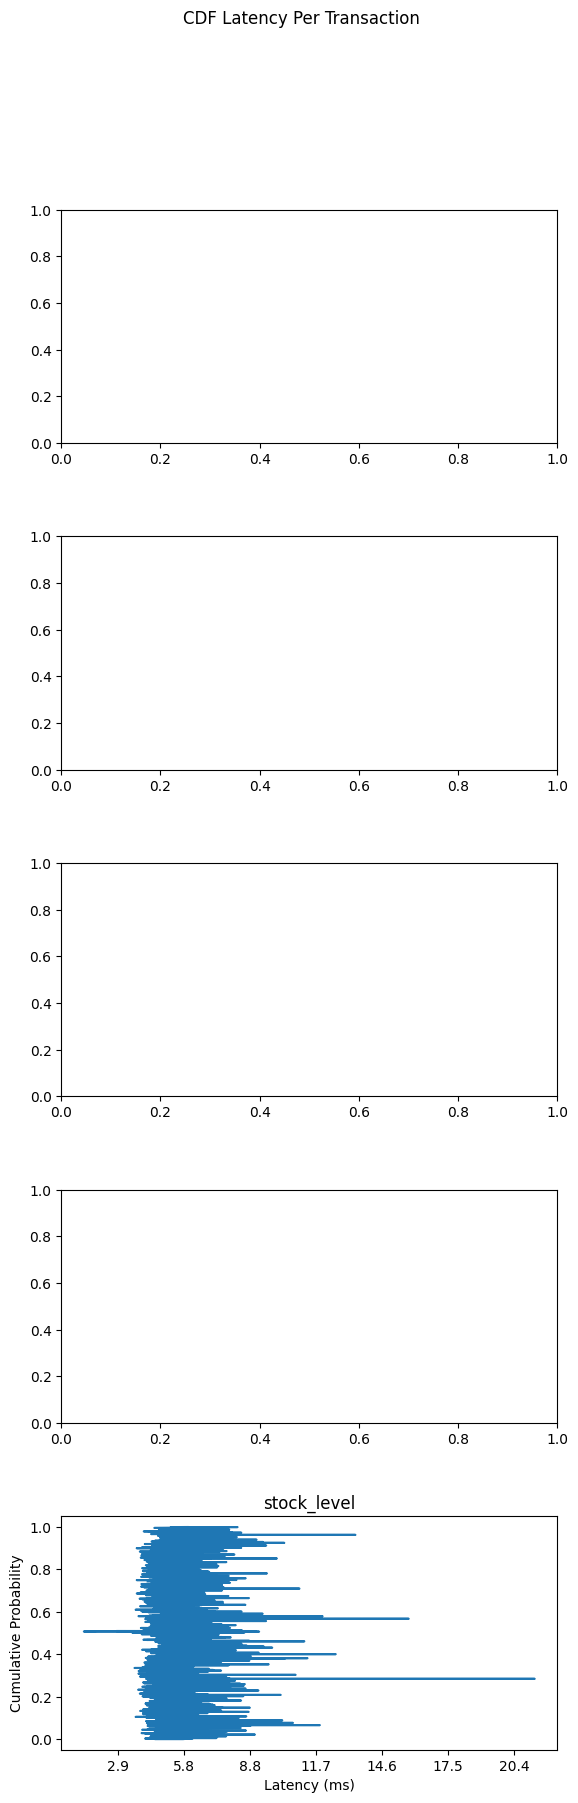

In [7]:
# Cumulative Distribution Function
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('CDF Latency Per Transaction')
for i, key in enumerate(data):
    cumsum = np.arange(1, len(data[key]) + 1) / len(data[key])
axes[i].plot(data[key], cumsum)
axes[i].set_title(key)
axes[i].set_xlabel('Latency (ms)')
axes[i].set_ylabel('Cumulative Probability')
axes[i].xaxis.set_major_formatter(mtick.PercentFormatter(len(data[key]), symbol=''))
figure.savefig(os.path.join(RESULTS_DIR, 'cdf_latency.png'))

# Metrics

In [8]:
latency_quantiles = [[key,
                      round(data[key].quantile(q=0.5), 4),
                      round(data[key].quantile(q=0.9), 4),
                      round(data[key].quantile(q=0.95), 4),
                      round(data[key].quantile(q=0.99), 4)]
                     for key in data]
df = pd.DataFrame(latency_quantiles, columns=['Transaction', 'P50', 'P90', 'P95', 'P99'])
df.to_csv(os.path.join(RESULTS_DIR, 'latency_quantiles.csv'), index=False)
df

,Transaction,P50,P90,P95,P99
0,payment,21.6882,38.8389,44.0662,168.5466
1,order,35.9730,52.7108,59.3772,182.1159
2,delivery,47.3330,63.8602,70.4776,190.5930
3,order_status,17.9045,29.9767,35.8556,53.8891
4,stock_level,182.5354,230.1847,252.3142,301.1658


In [9]:
data['order'].describe()

count    39626.000000
mean        40.241404
std         25.073054
min         18.295288
25%         29.587567
50%         35.972953
75%         43.707788
max        465.270996
dtype: float64

# All Together

In [9]:
sort_order = ['order', 'payment', 'order_status', 'delivery', 'stock_level']

In [18]:
experiments = os.listdir('results')
for experiment in experiments:
    df = pd.read_csv(f'results/{experiment}/latency_quantiles.csv')
    print(df.sort_values(by='Transaction', key=lambda x: sort_order.index(x[1])))

TypeError: object of type 'int' has no len()

1